In [1]:
#!/usr/bin/env python
from sqlalchemy import create_engine
from sqlalchemy import MetaData
from sqlalchemy import Table, Column, ForeignKey
from sqlalchemy import Integer, String
from sqlalchemy import sql, select, join, desc
from sqlalchemy import insert
from sqlalchemy.sql import func

import pandas as pd

import matplotlib.pyplot as plt

In [2]:
# Create a Engine object which is our handle into the database.
engine = create_engine('sqlite:///world.sqlite')

# Connect to the database
conn = engine.connect()

# Read the metadata from the existing database.
#  Since the database already exists and has tables defined, we can create Python objects based on these automatically.
DBInfo=MetaData(engine)

In [3]:
# Auto-create the objects based on the metadata read into the DBInfo.
country=Table('country', DBInfo, autoload=True)
city=Table('city', DBInfo, autoload=True)

### Insert values to country table

In [4]:
# Defining a function to insert Code, Name, Continent, Region, SurfaceArea, IndepYear, Population into country table
def insert_country(x1,x2,x3,x4,x5,x6,x7):
    qry1=insert(country).values(Code=x1, Name=x2, Continent=x3, Region=x4, SurfaceArea=x5, IndepYear=x6, Population=x7)
    result=conn.execute(qry1)

In [5]:
# defining a function to return country table
def get_country():
    # Select all from country table
    query = select([country.c.Code,country.c.Name,country.c.Continent,country.c.Region,country.c.SurfaceArea,country.c.IndepYear,country.c.Population])
    # Reading SQL query results into a Pandas data frame
    df=pd.read_sql(query, conn)
    return df

In [6]:
# Show last 5 rows from country table
get_country().tail(5)

,Code,Name,Continent,Region,SurfaceArea,IndepYear,Population
234,YEM,Yemen,Asia,Middle East,527968.0,1918.0,18112000
235,YUG,Yugoslavia,Europe,Southern Europe,102173.0,1918.0,10640000
236,ZAF,South Africa,Africa,Southern Africa,1221037.0,1910.0,40377000
237,ZMB,Zambia,Africa,Eastern Africa,752618.0,1964.0,9169000
238,ZWE,Zimbabwe,Africa,Eastern Africa,390757.0,1980.0,11669000


In [7]:
# Insert new row using pre-defined function 'insert_country()'
insert_country('XXK','Kosovo','Europe','Southeastern Europe',4203,2008,1873000)

In [8]:
# Show last 5 rows from country table after inserting new row
get_country().tail(5)

,Code,Name,Continent,Region,SurfaceArea,IndepYear,Population
235,YUG,Yugoslavia,Europe,Southern Europe,102173.0,1918.0,10640000
236,ZAF,South Africa,Africa,Southern Africa,1221037.0,1910.0,40377000
237,ZMB,Zambia,Africa,Eastern Africa,752618.0,1964.0,9169000
238,ZWE,Zimbabwe,Africa,Eastern Africa,390757.0,1980.0,11669000
239,XXK,Kosovo,Europe,Southeastern Europe,4203.0,2008.0,1873000


### Use JOIN

In [9]:
# Mirroring this command: SELECT country.Code, country.Population, SUM(city.Population), country.LifeExpectancy FROM country JOIN city ON Code=CountryCode GROUP BY Code;
query=select([country.c.Code, country.c.Population, func.sum(city.c.Population).label("sum_city_population"), country.c.LifeExpectancy])
query=query.select_from(join(query.froms[0], city, country.c.Code==city.c.CountryCode)).group_by(country.c.Code)

# Reading SQL query results into a Pandas data frame
df1=pd.read_sql(query, conn)
df1.head(5)

,Code,Population,sum_city_population,LifeExpectancy
0,ABW,103000,29034,78.4
1,AFG,22720000,2332100,45.9
2,AGO,12878000,2561600,38.3
3,AIA,8000,1556,76.1
4,ALB,3401200,270000,71.6


In [10]:
# Get the ratio by dividing 'sum_city_population' column by 'Population' column,
# and assign it to a new column named 'ratio'
df1["ratio"] = df1["sum_city_population"]/df1["Population"]
df1.head()

,Code,Population,sum_city_population,LifeExpectancy,ratio
0,ABW,103000,29034,78.4,0.281883
1,AFG,22720000,2332100,45.9,0.102645
2,AGO,12878000,2561600,38.3,0.198913
3,AIA,8000,1556,76.1,0.194500
4,ALB,3401200,270000,71.6,0.079384


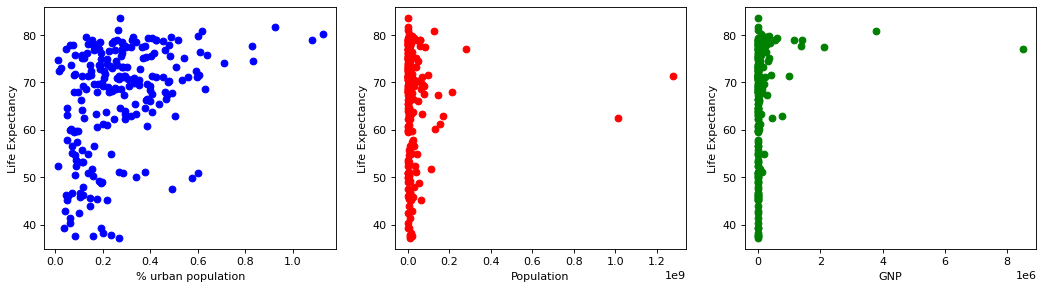

In [11]:
# Making the plots

# Reading SQL query 'SELECT Population, LifeExpectancy FROM country' to a data frame
df2=pd.read_sql(select([country.c.Population, country.c.LifeExpectancy, country.c.GNP]), conn)

fig = plt.figure(figsize=(16, 4), dpi=80)
ax = fig.add_subplot(131)
plt.scatter(list(df1['ratio']), list(df1['LifeExpectancy']),color='blue')
plt.xlabel('% urban population')
plt.ylabel('Life Expectancy')

ax = fig.add_subplot(132)
plt.scatter(list(df2['Population']), list(df2['LifeExpectancy']),color='red')
plt.xlabel('Population')
plt.ylabel('Life Expectancy')

ax = fig.add_subplot(133)
plt.scatter(list(df2['GNP']), list(df2['LifeExpectancy']),color='green')
plt.xlabel('GNP')
plt.ylabel('Life Expectancy')

plt.show()